In [1]:
%load_ext autotime

In [2]:
# time: 1.16 s

import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from lib.Text_Pre_Processing_in_Python import Preprocess
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)

time: 1.53 s


In [3]:
# time: 235 µs

vectorizer_max_features = 1500

time: 308 µs


In [4]:
# time: 6.5 s

all_text = pd.read_csv('archive/sub_reddits.csv', low_memory=False)
all_text['selftext'] = all_text['selftext'].astype(str)

time: 6.02 s


In [ ]:
# time: 22min 24s

prep = Preprocess.Preprocess()
sanitized_posts = []

for post in all_text['selftext']:
    document = re.sub(r'https*:\/\/[\w*\-*\.]*[\w\-*\/]*[\.\w]*[^\"\s]*', ' ', str(post))
    document = re.sub(r'\/[\w*\-*\.]*[\w\-*\/]*[\.\w]*[^\"\s]*', ' ', document)
    document = re.sub(r'amp;', '', document)
    document = " ".join(prep.preprocess(document))
    sanitized_posts.append(document)


In [ ]:
# time: 191 ms

with open('archive/pre_processed.pkl', 'wb') as picklefile:
    pickle.dump(sanitized_posts, picklefile)

In [5]:
# time: 238 ms

with open('archive/pre_processed.pkl', 'rb') as picklefile:
    sanitized_posts_df = pd.DataFrame(pickle.load(picklefile), columns=["posts"])

time: 164 ms


In [6]:
# time: 2min 13s

sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != 'test']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != '']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != 'a']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != '_']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != ' ']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'].str.contains('[^\d^\s]')]
sanitized_posts_df['posts'] = sanitized_posts_df['posts'].astype(str)

sanitized_posts_df.to_csv('archive/sanitized.csv', index=False)

time: 2.8 s


In [ ]:
# time: 703 µs

# Workspace for additional text cleaning

In [ ]:
# time: 1.53 s

sanitized_posts_df = pd.read_csv('archive/sanitized.csv')

# The following section runs a Latent Semantic Analysis (LSA) on the corpus using TruncatedSVD

In [7]:
# time: 21.3 s

count_vectorizer = CountVectorizer(min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
count_vectorized_posts = count_vectorizer.fit_transform(sanitized_posts_df['posts'])

time: 11.6 s


In [8]:
# time: 5 s

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_fit_transform = svd.fit_transform(count_vectorized_posts)

print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.08531383 0.0358968 ]
0.12121062187975334
[1764.347536   1021.85041969]
time: 3.95 s


In [9]:
# time: 63.8 ms

topic_word = pd.DataFrame(svd.components_.round(3), index=["component_1", "component_2"], columns=count_vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaaa,aaarated,aaba,aaii,aal,aamrq,aaoi,aap,...,не,рынке,уоu,это,ісо,الاستثمار,في,كما,من,ﬁnancial
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.000,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


time: 57.7 ms


In [10]:
# time: 478 µs

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

time: 630 µs


In [11]:
# time: 37.7 ms

display_topics(svd, count_vectorizer.get_feature_names(), 5)


Topic  0
stock, market, company, ha, gt

Topic  1
gt, earnings, click, release, estimate
time: 29.3 ms


In [12]:
# time: 25 ms

Vt = pd.DataFrame(svd_fit_transform.round(5),
             index = sanitized_posts_df['posts'],
             columns = ["component_1","component_2" ])
Vt

,component_1,component_2
posts,,
sober judge go sleep idea get go write notepad good idea get better one submit wrote expected variance time option put call price linear function respect time maximize call putt cost v gross rev combined prob dist stock price profit maybe get something going submit get working program use subreddits like department lol,2.36497,-1.34438
sold first house project house lived renovating part time past year profit need invest money used part payment next house roughly year couple idea would like hear would situation edit etf large portion investment pro personal thought favorite fund etc,1.73933,-1.16956
heard story numerous nonpenny stock sold penny level thursday pretty obvious happened us government must instructed largest volume trader institutional trader dump large volume stock penny level right pm eastern time thursday orchestrated effort drive key us stock market index thereby dramatically devalue us stock market objection would nt institution lose combined billion dollar dumping stock penny level yes indeed would believe us federal reserve promised recoup institution whatever loss incurred objection secret china among country ha trying slow economy stop currency quickly devalued hard imagine us would want thing covertly us dollar ha severely devalued recently week one ha wonder firm gained us stock sold penny level suspect could chinese investor word possible china took gigantic windfall profit expense us stock market precisely nt want take one us market manipulation capability assert dominance chinese market manipulation capability know seems counterintuitive doe idea slowing economy order bolster currency would surprised see currency warfare continue month big chinese firm learn fight back thursday proved american innovation leap bound ahead chinese regard market currency manipulation dollar ridiculously stronger today wa day ago euro yuan,7.82623,-1.04399
want learn type investing may decide focus study certain area specifically shortly lot time hand love read study new thing doe anyone resource share book buy online literature etc,0.89596,-0.44616
someone recommend good charting site see stock big long list displaying one year chart option would nice preferably moving average rsi etc use yahoo finance clicking stock take way long,1.66529,-0.51318
...,...,...
disclaimer long equity please due diligence based minute quick analysis company overview xeris spec pharma company founded primary scope work involves developed injectable infusible drug present product launch first product wa approved september called gvoke pfs autoinjector ha glucagon treat severe hypoglycemia market two different product gvoke pfs nov gvoke hypopen july competition primary competition come tradition glucagon kit eli lilly ’ baqsimi baqsimi delivered via nasal passage legacy kit traditional syringe injection xeris ha advantage pfs autoinjector traditionally well received patient xb baqsimi xb legacy kit xb financials popular product likely twopack hypopen autoinjector carry awp adult prescription mg baqsimi cost similar mg dosage legacy kit lly cost xb gvoke micromedex one overhang xeris ’ financials longterm debt ha increased ye q however principal payment start interest expense year xeris generating enough fcf next two year service debt valuation takeaways · peak sale · wacc · positive ebitda xb dcf xb price target,3.71300,-0.58004
month ago ran across forum similar reddit people could anonymously publish short thesis unfortunately unable find since doe anyone know still know talking,0.70045,-0.31436
love researching quality information interesting company however hard find intersection intriguing yet understandable outsider unfortunately rule pharma example really enjoyed following tesla always passionate alternative source energy lowcost airline flying around europe since wa month old love ryanair wizz though nt actually invested two u lowcost airline instead interesting note usually engaging company better ha

time: 23.1 ms


# TODO Figure out cosine_similarity

In [13]:
# time: 4.09 ms

from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity((topic_word.iloc[0], topic_word.iloc[1])).round()

array([[1., 0.],
       [0., 1.]])

time: 3.69 ms


# Implementing NMF

In [14]:
# time: 20.3 s

NMF_vectorizer = CountVectorizer(stop_words='english')
NMF_posts = NMF_vectorizer.fit_transform(sanitized_posts_df['posts'])

time: 11.8 s


In [15]:
# time: 8.25 s

from sklearn.decomposition import NMF

nmf_model = NMF(2, random_state=42)
NMF_nmf = nmf_model.fit_transform(NMF_posts)

time: 6.84 s


In [16]:
# time: 382 ms

NMF_df = pd.DataFrame(nmf_model.components_.round(3), index=['component_1', 'component_2'], columns=NMF_vectorizer.get_feature_names())

NMF_df

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh,aaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh,...,𝕊ℙ𝕐,𝗳𝗿𝗮𝗰𝘁𝗶𝗼𝗻,𝗹𝗲𝘀𝘀,𝗼𝗳,𝗽𝗿𝗶𝗰𝗲,𝘁𝗵𝗮𝗻,𝘁𝗵𝗲,𝘐𝘯𝘵𝘦𝘭𝘭𝘪𝘨𝘦𝘯𝘵,𝘐𝘯𝘷𝘦𝘴𝘵𝘰𝘳,𝘛𝘩𝘦
component_1,0.019,0.020,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.003,0.005,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 249 ms


In [17]:
# time: 295 ms

display_topics(nmf_model, NMF_vectorizer.get_feature_names(), 10)


Topic  0
stock, market, company, wa, year, nt, price, ha, like, money

Topic  1
gt, earnings, ha, click, company, market, stock, release, estimate, week
time: 132 ms


# Latent Dirichlet Allocation

In [18]:
# time: 17 s

LDA_vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english', lowercase=True, token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.5, min_df=10)

LDA_transformed = LDA_vectorizer.fit_transform(sanitized_posts_df['posts'])

time: 14.1 s


In [19]:
# time: 17.6 s

LDA_Tf_vectorizer = TfidfVectorizer(**LDA_vectorizer.get_params())

tfidfvectorized_posts = LDA_Tf_vectorizer.fit_transform(sanitized_posts_df['posts'])

time: 14.5 s


In [20]:
# time: 17.3 s

tfidf_df = pd.DataFrame(tfidfvectorized_posts.toarray(), columns=LDA_vectorizer.get_feature_names())
tfidf_df.head()

,aaa,aaarated,aaii,aal,aamrq,aaoi,aap,aapl,aaplo,aar,...,zscore,zte,zts,zucc,zuck,zuckerberg,zuo,zurich,zweig,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 7.05 s


In [21]:
# time: 39min 22s

# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf.fit(LDA_transformed)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tfidf.fit(tfidfvectorized_posts)

LatentDirichletAllocation(n_components=5, random_state=0)

time: 42min 50s


In [22]:
# time: 6.46 ms

with open('archive/lda.20.0.pkl', 'wb') as picklefile:
    pickle.dump(lda_tfidf, picklefile)
with open('archive/lda_tfidf.20.0.pkl', 'wb') as picklefile:
    pickle.dump(lda_tfidf, picklefile)

time: 5.04 ms


In [ ]:
# time: 4.84 ms

with open('archive/lda.20.0.pkl', 'rb') as picklefile:
    lda_tf= pickle.load(picklefile)
with open('archive/lda_tfidf.20.0.pkl', 'rb') as picklefile:
    lda_tfidf = pickle.load(picklefile)

In [23]:
# time: 56.1 s

trans_lda = lda_tfidf.transform(tfidfvectorized_posts)

time: 1min 3s


In [37]:
# time: 188 ms

import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

time: 97.6 ms
/Users/albertlee/.vscode/extensions/ms-python.python-2020.10.332292344/pythonFiles/lib/python/past/types/oldstr.py:23: DeprecationWarning: invalid escape sequence \d
  """


In [38]:
# time: 1min 45s

pyLDAvis.sklearn.prepare(lda_tf, LDA_transformed, LDA_Tf_vectorizer)

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.116104 -0.006983       1        1  23.350046
3     -0.070386  0.062763       2        1  22.459394
0      0.069705  0.153018       3        1  21.342251
2      0.096613 -0.161058       4        1  21.341522
1     -0.212036 -0.047740       5        1  11.506788, topic_info=             Term          Freq         Total Category  logprob  loglift
12798      option  53495.000000  53495.000000  Default  30.0000  30.0000
7573         fund  50639.000000  50639.000000  Default  29.0000  29.0000
3498      company  75361.000000  75361.000000  Default  28.0000  28.0000
9697    investing  35156.000000  35156.000000  Default  27.0000  27.0000
129       account  35006.000000  35006.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
8472         help   5872.186655  17355.904975   Topic5  -5.2576   1.0785
13754       point   5955.302429  18986.573490   Topic5  -5.2436   1.0028
18606       think   6508.755022  40119.524479   Topic5  -5.1547   0.3435
2485          buy   6536.667078  49984.789862   Topic5  -5.1504   0.1279
9700   investment   6228.489768  34029.910997   Topic5  -5.1987   0.4641

[462 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
7          1  0.018105  aapl
7          2  0.030662  aapl
7          3  0.924520  aapl
7          4  0.018689  aapl
7          5  0.007884  aapl
...      ...       ...   ...
20917      2  0.525056  year
20917      3  0.023002  year
20917      4  0.232709  year
20917      5  0.037053  year
20985      5  0.999635   yrs

[1185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

time: 1min 53s


In [39]:
# time: 54.9 s

pyLDAvis.sklearn.prepare(lda_tfidf, tfidfvectorized_posts, LDA_Tf_vectorizer)

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.065266 -0.064501       1        1  28.278389
0     -0.137417 -0.011018       2        1  23.921488
3     -0.007398  0.110962       3        1  23.743394
1      0.098230  0.068887       4        1  13.805472
2      0.111852 -0.104331       5        1  10.251257, topic_info=            Term         Freq        Total Category  logprob  loglift
7573        fund  3510.000000  3510.000000  Default  30.0000  30.0000
809       answer  1493.000000  1493.000000  Default  29.0000  29.0000
9697   investing  3008.000000  3008.000000  Default  28.0000  28.0000
129      account  2743.000000  2743.000000  Default  27.0000  27.0000
6984   financial  1625.000000  1625.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
12215       news   303.568332  1251.173650   Topic5  -5.8518   0.8615
10772    looking   362.148929  2895.525466   Topic5  -5.6754   0.1989
12798     option   355.332311  3915.356864   Topic5  -5.6944  -0.1218
3498     company   343.772866  4193.381843   Topic5  -5.7275  -0.2235
8204         guy   294.404642  2204.940193   Topic5  -5.8825   0.2643

[445 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
100        1  0.104784  access
100        2  0.007310  access
100        3  0.280235  access
100        4  0.095036  access
100        5  0.511734  access
...      ...       ...     ...
20917      4  0.089904    year
20917      5  0.029558    year
20940      1  0.975415     yen
20985      3  0.029293     yrs
20985      4  0.969589     yrs

[1201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])

time: 1min 7s


In [40]:
# time: 1min 40s

pyLDAvis.sklearn.prepare(lda_tf, LDA_transformed, LDA_Tf_vectorizer, mds='mmds')

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.114242  0.123007       1        1  23.350046
3      0.004766 -0.150664       2        1  22.459394
0     -0.179039 -0.067393       3        1  21.342251
2      0.074032  0.179370       4        1  21.341522
1      0.214484 -0.084321       5        1  11.506788, topic_info=             Term          Freq         Total Category  logprob  loglift
12798      option  53495.000000  53495.000000  Default  30.0000  30.0000
7573         fund  50639.000000  50639.000000  Default  29.0000  29.0000
3498      company  75361.000000  75361.000000  Default  28.0000  28.0000
9697    investing  35156.000000  35156.000000  Default  27.0000  27.0000
129       account  35006.000000  35006.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
8472         help   5872.186655  17355.904975   Topic5  -5.2576   1.0785
13754       point   5955.302429  18986.573490   Topic5  -5.2436   1.0028
18606       think   6508.755022  40119.524479   Topic5  -5.1547   0.3435
2485          buy   6536.667078  49984.789862   Topic5  -5.1504   0.1279
9700   investment   6228.489768  34029.910997   Topic5  -5.1987   0.4641

[462 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
7          1  0.018105  aapl
7          2  0.030662  aapl
7          3  0.924520  aapl
7          4  0.018689  aapl
7          5  0.007884  aapl
...      ...       ...   ...
20917      2  0.525056  year
20917      3  0.023002  year
20917      4  0.232709  year
20917      5  0.037053  year
20985      5  0.999635   yrs

[1185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

time: 1min 52s


In [41]:
# time: 1min 34s

pyLDAvis.sklearn.prepare(lda_tf, LDA_transformed, LDA_Tf_vectorizer, mds='tsne')

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  23.350046
3       51.163364 -159.968018       2        1  22.459394
0      -73.144554   21.523815       3        1  21.342251
2      -66.410133 -110.606438       4        1  21.341522
1       54.417324   12.443444       5        1  11.506788, topic_info=             Term          Freq         Total Category  logprob  loglift
12798      option  53495.000000  53495.000000  Default  30.0000  30.0000
7573         fund  50639.000000  50639.000000  Default  29.0000  29.0000
3498      company  75361.000000  75361.000000  Default  28.0000  28.0000
9697    investing  35156.000000  35156.000000  Default  27.0000  27.0000
129       account  35006.000000  35006.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
8472         help   5872.186655  17355.904975   Topic5  -5.2576   1.0785
13754       point   5955.302429  18986.573490   Topic5  -5.2436   1.0028
18606       think   6508.755022  40119.524479   Topic5  -5.1547   0.3435
2485          buy   6536.667078  49984.789862   Topic5  -5.1504   0.1279
9700   investment   6228.489768  34029.910997   Topic5  -5.1987   0.4641

[462 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
7          1  0.018105  aapl
7          2  0.030662  aapl
7          3  0.924520  aapl
7          4  0.018689  aapl
7          5  0.007884  aapl
...      ...       ...   ...
20917      2  0.525056  year
20917      3  0.023002  year
20917      4  0.232709  year
20917      5  0.037053  year
20985      5  0.999635   yrs

[1185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

time: 1min 53s


In [51]:
# time: 561 ms

import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 1.83 s


In [52]:
# time: 17.5 s

cor_vectorizer = CountVectorizer(max_features=20000, stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", binary=True)

cor_posts = cor_vectorizer.fit_transform(sanitized_posts_df['posts'])
cor_words = list(np.asarray(cor_vectorizer.get_feature_names()))

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 11.5 s


In [53]:
# time: 51.3 s

topic_model = ct.Corex(n_hidden=6, words=cor_words, seed=1)
topic_model.fit(cor_posts, words=cor_words, docs=sanitized_posts_df['posts'])

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 49 s


In [54]:
# time: 19.8 ms

topics = topic_model.get_topics()
for n, topic in enumerate(topics):
    topic_words, _ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: ha,company,business,revenue,said,million,new,billion,product,industry
1: people,going,shit,fucking,fuck,world,come,virus,covid,economy
2: market,value,nt,return,stock,long,high,rate,portfolio,term
3: price,day,wa,sell,week,option,position,profit,strike,close
4: blackjack,yrs,rep,risking,objective,employed,registered,redditors,useful,tolerance
5: money,fund,year,account,time,investing,saving,investment,need,income
time: 21.5 ms
/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# time: 227 ms

topic_model.get_top_docs(topic=4, n_docs=2)

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('welcome monday moron monday want ask one question worried ask felt might make sound like moron fine member r fielding question basic advanced go ahead ask away note question single answer question also need lot information give sort answer old employed income much objective money buy house retirement saving risk tolerance mind risking blackjack need know safe current holding already exposure specific fund sector asset house paid car expensive girlfriend really asset time horizon need money next month next yrs big debt relevant financial information useful give proper answer aware answer opinion redditors used starting point research strongly consider seeing registered financial rep making financial decision',
  0.0),
 ('question anything similar single answer question also need lot information give sort answer old employed income much objective money buy house retirement saving risk tolerance mind risking blackjack need know safe current holding already exposure specific fund sector

time: 135 ms


In [56]:
# time: 372 ms

predictions = pd.DataFrame(topic_model.predict(cor_posts), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic0,topic1,topic2,topic3,topic4,topic5
0,False,False,False,False,False,False
1,False,False,False,False,False,True
2,True,True,True,True,False,False


time: 256 ms


/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


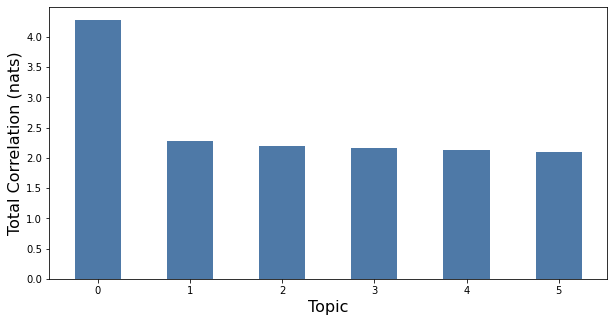

time: 343 ms


In [57]:
# time: 208 ms

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [64]:
# time: 1min 40s
n_hidden = 20

topic_model = ct.Corex(n_hidden=n_hidden, words=cor_words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(cor_posts, words=cor_words, docs=sanitized_posts_df['posts'], 
                anchors=[['options'],
                         ['tendies'], 
                         ['yolo'],
                         ['stock'],
                         ['stonk'],
                         ['etf'],
                         ['bond'],
                         ['trump'],
                         ['hillary'],
                         ['god'], 
                         ['politics']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0: blackjack,yrs,rep,risking,objective,employed,registered,redditors,useful,proper
1: people,tendies,going,virus,dr,tl,fed,coming,hit,home
2: week,day,position,spy,yolo,shit,today,close,fucking,fuck
3: stock,price,sell,option,buy,make,share,profit,strike,selling
4: level,strong,continue,trend,support,line,news,positive,expect,despite
5: etf,fund,year,account,ira,vanguard,roth,index,investment,portfolio
6: bond,rate,cash,equity,yield,loan,bank,estate,real,capital
7: trump,business,said,china,world,economy,million,country,billion,state
8: increase,result,quarter,number,likely,economic,sale,expected,report,increas

In [79]:
# time: 9.72 s

for i in range(n_hidden):
    print(topic_model.get_top_docs(topic=i, n_docs=2))

ing earnings release day moving average overall earnings estimate revised lower since company last earnings release friday may wa notable buying contract put expiring friday may option trader pricing move earnings stock ha averaged move recent quarter gt click chart cisco system inc gt cisco system inc csco confirmed report earnings approximately pm et wednesday may consensus earnings estimate per share revenue billion earnings whisper ® number per share investor sentiment going company earnings release ha expecting earnings beat company guidance wa earnings per share consensus estimate earnings decline yearoveryear revenue decreasing short interest ha decreased since company last earnings release stock ha drifted lower open following earnings release day moving average overall earnings estimate revised lower since company last earnings release friday may wa notable buying contract call expiring friday may option trader pricing move earnings stock ha averaged move recent quarter gt cli

In [81]:
vt.vis_rep(topic_model, prefix='topic-model-example')

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'NoneType' object has no attribute 'shape'

# Word2Vec

In [65]:
# time: 56 s

wv_vectorizer = CountVectorizer(ngram_range=(1, 2))

wv_vectorizer.fit(all_text['selftext'])

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CountVectorizer(ngram_range=(1, 2))

time: 58.9 s


In [66]:
# time: 42.7 s

wv = wv_vectorizer.transform(all_text['selftext'])

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 45.3 s


In [67]:
# time: 2.41 s

with open('archive/wv_vectorizer.pkl', "wb") as picklefile:
    pickle.dump(wv_vectorizer, picklefile)

with open('archive/wv_vectorized.pkl', "wb") as picklefile:
    pickle.dump(wv, picklefile)

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 2.06 s


In [68]:
# Crashes my machine.
wv_array = wv.toarray()

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 1min 5s


In [69]:
pd.DataFrame(wv_array, columns=wv_vectorizer.get_feature_names())

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,00,00 00,00 000,00 00025,00 0025,00 003,00 004,00 005,00 00pm,00 01,...,𝘁𝗵𝗲,𝘁𝗵𝗲 𝗽𝗿𝗶𝗰𝗲,𝘐𝘯𝘵𝘦𝘭𝘭𝘪𝘨𝘦𝘯𝘵,𝘐𝘯𝘵𝘦𝘭𝘭𝘪𝘨𝘦𝘯𝘵 𝘐𝘯𝘷𝘦𝘴𝘵𝘰𝘳,𝘐𝘯𝘷𝘦𝘴𝘵𝘰𝘳,𝘐𝘯𝘷𝘦𝘴𝘵𝘰𝘳 which,𝘛𝘩𝘦,𝘛𝘩𝘦 𝘐𝘯𝘵𝘦𝘭𝘭𝘪𝘨𝘦𝘯𝘵,𝟐𝟓,𝟐𝟓 𝐝𝐚𝐲
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 9.82 s


# Doc2Vec

In [70]:
import gensim
import gensim.downloader as api
dataset = api.load("text8")
data = [d for d in dataset]

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
time: 3.5 s


In [71]:
# time: 2.07 s

def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(tagged_document(all_text['selftext']))

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 1.6 s


In [72]:
# time: 297 µs

print(data_for_training [:1])

[TaggedDocument(words='So I\'m sober as a judge, about to go to sleep when I have this idea and I get up and go write it down in notepad, because that\'s a good idea.  Then I get a better one which is to submit it here. So here is what I wrote:\n"expected variance over time, options put and call prices, are they a linear function with respect to time?\nmaximize call and putt cost vs gross rev combined with prob dist of stock price\nprofit"\nMaybe if we get something going we can submit it to /r/programing and get a working program?  Use subreddits like departments. lol?', tags=[0])]
time: 1.05 ms
/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# time: 2.27 ms

model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)

time: 953 µs
/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# time: 1min 14s

model.build_vocab(data_for_training)

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 1min 3s


In [75]:
# time: 20min 20s

model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
time: 18min 37s


In [76]:
# time: 5.2 ms
# TODO fix infer_vector list
print(model.infer_vector(['option', 'stock', 'tendie', 'yolo']))

[ 9.31561086e-03  6.40035281e-03 -9.44113638e-03  1.11876065e-02
  1.15010813e-02 -7.94195943e-03  9.66850482e-03  3.11025092e-03
  1.10069737e-02 -6.17308356e-03  1.49482011e-03 -3.93324113e-03
 -8.30666441e-03  5.09303017e-03  6.47823501e-04 -7.90085830e-03
  9.11832135e-03  7.00838500e-05 -9.43298452e-03 -5.62164374e-03
 -4.26938385e-03 -1.24618108e-03  7.70784169e-03  9.95286088e-03
  1.21358205e-02 -9.67403699e-04  1.02516031e-02 -2.96357018e-03
  5.62664540e-03 -2.57568667e-03  3.79349757e-03 -6.71499502e-03
 -3.55838588e-03 -1.15073193e-02 -2.61182897e-04 -1.18985109e-03
  4.22165729e-03 -5.15035307e-03 -1.10279594e-03  8.34684912e-03]
time: 5.54 ms
/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPytho

In [77]:
# time: 52.4 ms

with open('archive/gensim_model.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

time: 52.4 ms
/Users/albertlee/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# PCA

In [7]:
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm

time: 441 µs


In [8]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)

time: 403 µs


In [9]:
cvp_arr = count_vectorized_posts.toarray()
cvp_df = pd.DataFrame(cvp_arr)
cvp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31628,31629,31630,31631,31632,31633,31634,31635,31636,31637
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 7.79 s


In [10]:
# time: 17min 45s - 150,000 wsb entries
# crashes
pca.fit(cvp_df)
pcafeatures_train = pca.transform(cvp_df)

PCA(n_components=2)

time: 17min 45s


In [14]:
with open('archive/pca.pkl', 'wb') as picklefile:
    pickle.dump(pca, picklefile)

time: 9.97 ms


In [16]:
# create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r', 'g', 'b', 'c' , 'm', 'y', 'orange', 'w', 'aqua', 'yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10, 10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1], c=c, label=label, edgecolors='gray')
    plt.legend()

time: 658 µs


In [ ]:
# plot of all the numbers
plot_PCA_2D(pcafeatures_train, target=, target_names=digits.target_names)

# KMeans

In [5]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

time: 105 ms


In [6]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X, km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

time: 659 µs


In [7]:
# time: 38.9 s

random_state = 0 

vec = TfidfVectorizer(stop_words="english")
vec.fit(all_text.selftext.values)
features = vec.transform(all_text.selftext.values)

time: 36.7 s


In [8]:
# time: 16 s

cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(n_clusters=5, random_state=0)

time: 15.6 s


In [9]:
# time: 5.88 s

# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([3, 3, 3, ..., 3, 4, 3], dtype=int32)

time: 5.8 s


In [10]:
# time: 390 µs

# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)

time: 340 µs


In [11]:
reduced_features_pca = pca.fit(features.toarray())


In [ ]:
reduced_features = pca.transform(reduced_features_pca.toarray())


In [ ]:
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)